# Лабораторная работа 1 по МО

Выбранный набор данных позволяет нам предсказать вероятность появления диабета у инидийских пим в течение 5 лет, исходя из различных медицинских параметров.

In [423]:
import pandas as pd
dataframe = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv', header=None)
dataframe.columns = ['Times pregnant', 'Glucose concentration', 'Blood pressure', 'Skinfold thickness', 'Serum insulin',
                     'BMI', 'Pedigree', 'Age', 'Class']
print(dataframe[dataframe == 0].count(axis=0)/len(dataframe.index))

Times pregnant           0.144531
Glucose concentration    0.006510
Blood pressure           0.045573
Skinfold thickness       0.295573
Serum insulin            0.486979
BMI                      0.014323
Pedigree                 0.000000
Age                      0.000000
Class                    0.651042
dtype: float64


Как можно заметить многие данные в таблице отсутствуют, но при этом важно отметить, что например отсутствие беременностей является важным статистическим параметром и его не стоит исключать из рассмотрения при этом параметр Serum insulin в половине случаев не имеет о себе данных и его следует исключить из рассмотрения, как и параметр Skinfold thickness, т.к. его данные отсутствуют в трети случаев.

Удаляем ненужные столбцы

In [424]:
del dataframe['Skinfold thickness']
del dataframe['Serum insulin']

При этом у нас всё ещё остаются недостающие данные в других атрибутах.Заменим их на стандартное оклонение по столбцам.

In [425]:
dataframe['Glucose concentration'] = dataframe['Glucose concentration'].replace(0, dataframe['Glucose concentration'].std())
dataframe['Blood pressure'] = dataframe['Blood pressure'].replace(0, dataframe['Blood pressure'].std())
dataframe['BMI'] = dataframe['BMI'].replace(0, dataframe['BMI'].std())
print(dataframe[dataframe == 0].count(axis=0)/len(dataframe.index))

Times pregnant           0.144531
Glucose concentration    0.000000
Blood pressure           0.000000
BMI                      0.000000
Pedigree                 0.000000
Age                      0.000000
Class                    0.651042
dtype: float64


Вывод статистических данных для атрибутов:

In [426]:
print(dataframe.head())
print("Размеры:",dataframe.shape)
print("Устройство:\n",dataframe.dtypes)

   Times pregnant  Glucose concentration  Blood pressure   BMI  Pedigree  Age  \
0               6                  148.0            72.0  33.6     0.627   50   
1               1                   85.0            66.0  26.6     0.351   31   
2               8                  183.0            64.0  23.3     0.672   32   
3               1                   89.0            66.0  28.1     0.167   21   
4               0                  137.0            40.0  43.1     2.288   33   

   Class  
0      1  
1      0  
2      1  
3      0  
4      1  
Размеры: (768, 7)
Устройство:
 Times pregnant             int64
Glucose concentration    float64
Blood pressure           float64
BMI                      float64
Pedigree                 float64
Age                        int64
Class                      int64
dtype: object


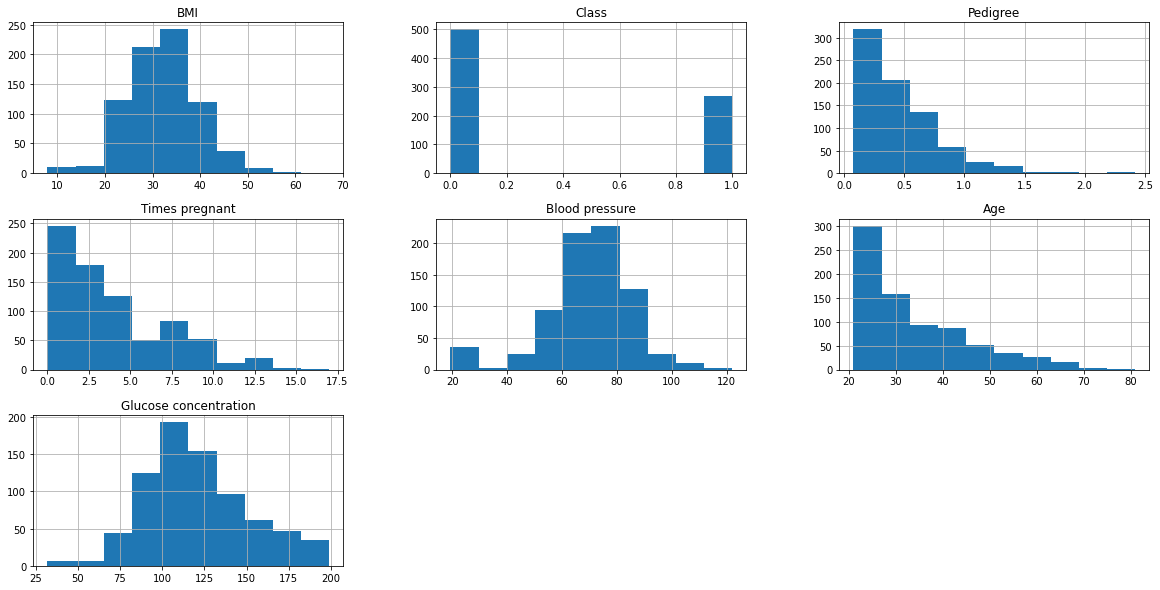

In [427]:
features = list(set(dataframe.columns))
dataframe[features].hist(figsize=(20,10))
pass

Можно заметить, что некоторые параметры распределены нормально:Blood pressure, Glucose concentration, BMI.
Причем многие распределения похожи на экспоненциальное распределение:Pedigree, Age, Times pregnant.

####Алгоритм K-ближайших соседей

Требуемые библиотеки для моей и стандартной реализации:
    

In [428]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn import metrics  
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

Реализация алгоритма K-ближайших соседей

In [429]:
def weighted_knn(data, p, k):
    distance = []
    for element in data:
        euclidean_distance = math.sqrt(
            (element[1][0] - p[0]) ** 2 + (element[1][1] - p[1]) ** 2 + (element[1][2] - p[2]) ** 2 + (element[1][3] - p[3]) ** 2 + (
                    element[1][4] - p[4]) ** 2 + (element[1][5] - p[5]) ** 2)
        distance.append((euclidean_distance, element[0]))
    distance = sorted(distance)[:k]
    freq1 = 0
    freq2 = 0
    for d in distance:
        if d[1] == 0:
            freq1 += (1 / d[0])

        elif d[1] == 1:
            freq2 += (1 / d[0])

    return 0 if freq1 > freq2 else 1

Подгружаем данные и переводим их в удобный формат:
    

In [430]:
X = dataframe.iloc[:, :-1].values
Y = dataframe.iloc[:, 6].values
Z = dataframe.iloc[:, :].values
k = 21

Разделяем данные на тестовую и обучающие выборки:
    

In [431]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,  random_state=0)
trans = StandardScaler()
trans2 = Normalizer()

Стандартизируем данные:

In [432]:
X_train = trans.fit_transform(X_train)
X_test = trans.fit_transform(X_test)

Для удобства вернем всё к начальному виду:

In [433]:
Z_train, Z_test = np.concatenate((X_train, Y_train[:,None]), axis=1), np.concatenate((X_test, Y_test[:,None]), axis=1)

Переводим данные в удобный формат:

In [434]:
df_listed_train = list(zip(Y_train, X_train))
df_listed_test = list(zip(Y_test, X_test))

Стандартная реализация через sklearn

In [435]:
classifier = KNeighborsClassifier(metric = 'minkowski', p = 2, n_neighbors=k)
classifier.fit(X_train, Y_train)
Y_pred = classifier.predict(X_test)
accuracy = metrics.accuracy_score(Y_pred,Y_test)   
print("Статистика для стандартной реализации:\n", accuracy, "при k =", k)

Статистика для стандартной реализации:
 0.8311688311688312 при k = 21


Проверка собственной реализации:
    

In [436]:
My_success = 0
for element in df_listed_test:
    if element[0] == weighted_knn(df_listed_train, element[1], k):
        My_success += 1       
print("Вероятность успеха реализованным мной методом:", My_success / len(df_listed_test), "при k =", k)

Вероятность успеха реализованным мной методом: 0.8311688311688312 при k = 21


Рассмотрим график зависимости ошибки от значения k:

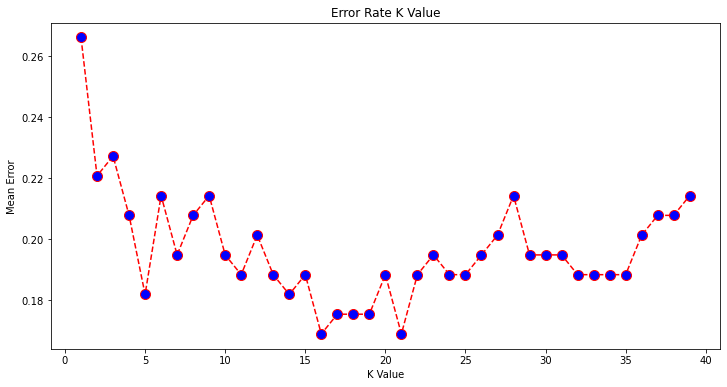

In [437]:
error = []
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, Y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != Y_test))
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')
pass

Как можем заметить ошибка наименее вероятна при кол-ве соседей равным 16 и 21.

####Алгоритм наивного Байесовского классификатора

Требуемые библиотеки для моей и стандартной реализации:

In [438]:
from math import sqrt
from math import exp
from math import pi
import random
import pandas as pd
import sklearn
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

Функции для реализации наивного Байесовского классификатора:

In [439]:
#разделяем обучающий набор по классам
def separate_by_class(dataset):
    tmp_dictionary = dict()
    for i in range(len(dataset)):
        vector = dataset[i]
        class_type = vector[-1]
        if (class_type not in tmp_dictionary):
            tmp_dictionary[class_type] = list()
        tmp_dictionary[class_type].append(vector)
    return tmp_dictionary

#рассчет среднего для атрибутов
def mean(numbers):
    return sum(numbers) / float(len(numbers))

#рассчет стандартного отклонения
def standart_deviation(numbers):
    avg = mean(numbers)
    variance = sum([(x - avg) ** 2 for x in numbers]) / float(len(numbers) - 1)
    return sqrt(variance)

#рассчет mean и standart_deviation для атрибутов
def attributes_count(dataset):
    summaries = [(mean(column), standart_deviation(column), len(column)) for column in zip(*dataset)]
    del (summaries[-1])
    return summaries


#делим наш набор по классам и считаем attributes_count
def attributes_by_class(dataset):
    classed = separate_by_class(dataset)
    result = dict()
    for class_value, rows in classed.items():
        result[class_value] = attributes_count(rows)
    return result

#вычисляем Гауссовскую функцию плотности вероятности
def calculate_prob(x, mean, standart_deviation):
    exponent = exp(-((x - mean) ** 2 / (2 * standart_deviation ** 2)))
    return (1 / (sqrt(2 * pi) * standart_deviation)) * exponent

#отображение значений классов на вероятности
def class_probs(summaries, row):
    total_rows = sum([summaries[label][0][2] for label in summaries])
    probabilities = dict()
    for class_value, class_summaries in summaries.items():
        probabilities[class_value] = summaries[class_value][0][2] / float(total_rows)
        for i in range(len(class_summaries)):
            mean, standart_deviation, _ = class_summaries[i]
            probabilities[class_value] *= calculate_prob(row[i], mean, standart_deviation)
    return probabilities

#делаем предсказание
def predict(summaries, row):
    probabilities = class_probs(summaries, row)
    best_label, best_prob = None, -1
    for class_value, probability in probabilities.items():
        if best_label is None or probability > best_prob:
            best_prob = probability
            best_label = class_value
    return best_label

Вывод результатов и сами рассчеты для метода реализации через sklearn:

In [440]:
gnb = GaussianNB()
Y_pred = gnb.fit(X_train, Y_train).predict(X_test)

standart_success = 0
my_success = 0
for i, j in zip(Y_test, Y_pred):
    if i == j:
        standart_success += 1
print("Статистика для стандартной реализации:\n", standart_success / len(Y_pred))

Статистика для стандартной реализации:
 0.8051948051948052


Вывод и подсчет результатов для самостоятельно реализованного алгоритма:

In [441]:
model = attributes_by_class(Z_train)
for i in Z_test:
    if i[-1] == predict(model, i):
        my_success += 1
print("Статистика для моей реализации:\n", my_success / len(Z_test))

Статистика для моей реализации:
 0.8051948051948052
